In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import missingno as msno


# Limpeza de dados

In [2]:
df = pd.read_csv("C:/Users/SAMSUNG/OneDrive/Documentos/GitHub/vendas_carros/dados/vehicles.csv")

In [3]:
df.head()

,id,url,region,region_url,price,year,manufacturer,model,condition,cylinders,...,size,type,paint_color,image_url,description,county,state,lat,long,posting_date
0,7222695916,https://prescott.craigslist.org/cto/d/prescott...,prescott,https://prescott.craigslist.org,6000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,az,NaN,NaN,NaN
1,7218891961,https://fayar.craigslist.org/ctd/d/bentonville...,fayetteville,https://fayar.craigslist.org,11900,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,ar,NaN,NaN,NaN
2,7221797935,https://keys.craigslist.org/cto/d/summerland-k...,florida keys,https://keys.craigslist.org,21000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,fl,NaN,NaN,NaN
3,7222270760,https://worcester.craigslist.org/cto/d/west-br...,worcester / central MA,https://worcester.craigslist.org,1500,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,ma,NaN,NaN,NaN
4,7210384030,https://greensboro.craigslist.org/cto/d/trinit...,greensboro,https://greensboro.craigslist.org,4900,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,nc,NaN,NaN,NaN


In [4]:
df.shape

(426880, 26)

In [5]:
df.dtypes

id                int64
url              object
region           object
region_url       object
price             int64
year            float64
manufacturer     object
model            object
condition        object
cylinders        object
fuel             object
odometer        float64
title_status     object
transmission     object
VIN              object
drive            object
size             object
type             object
paint_color      object
image_url        object
description      object
county          float64
state            object
lat             float64
long            float64
posting_date     object
dtype: object

In [6]:
df.duplicated().sum()

0

In [7]:
df.isnull().sum()

id                   0
url                  0
region               0
region_url           0
price                0
year              1205
manufacturer     17646
model             5277
condition       174104
cylinders       177678
fuel              3013
odometer          4400
title_status      8242
transmission      2556
VIN             161042
drive           130567
size            306361
type             92858
paint_color     130203
image_url           68
description         70
county          426880
state                0
lat               6549
long              6549
posting_date        68
dtype: int64

In [8]:
df.columns

Index(['id', 'url', 'region', 'region_url', 'price', 'year', 'manufacturer',
       'model', 'condition', 'cylinders', 'fuel', 'odometer', 'title_status',
       'transmission', 'VIN', 'drive', 'size', 'type', 'paint_color',
       'image_url', 'description', 'county', 'state', 'lat', 'long',
       'posting_date'],
      dtype='object')

In [9]:
#dropando colunas que não são uteis para a análise
df = df.drop(columns=['id', 'url','region_url','image_url', 'description','lat', 'long', 'VIN', 'county', 'posting_date'])

## Dados ausentes: overview

A maioria dos algoritmos não irá funcionar se houver dados ausentes. 

<AxesSubplot:>

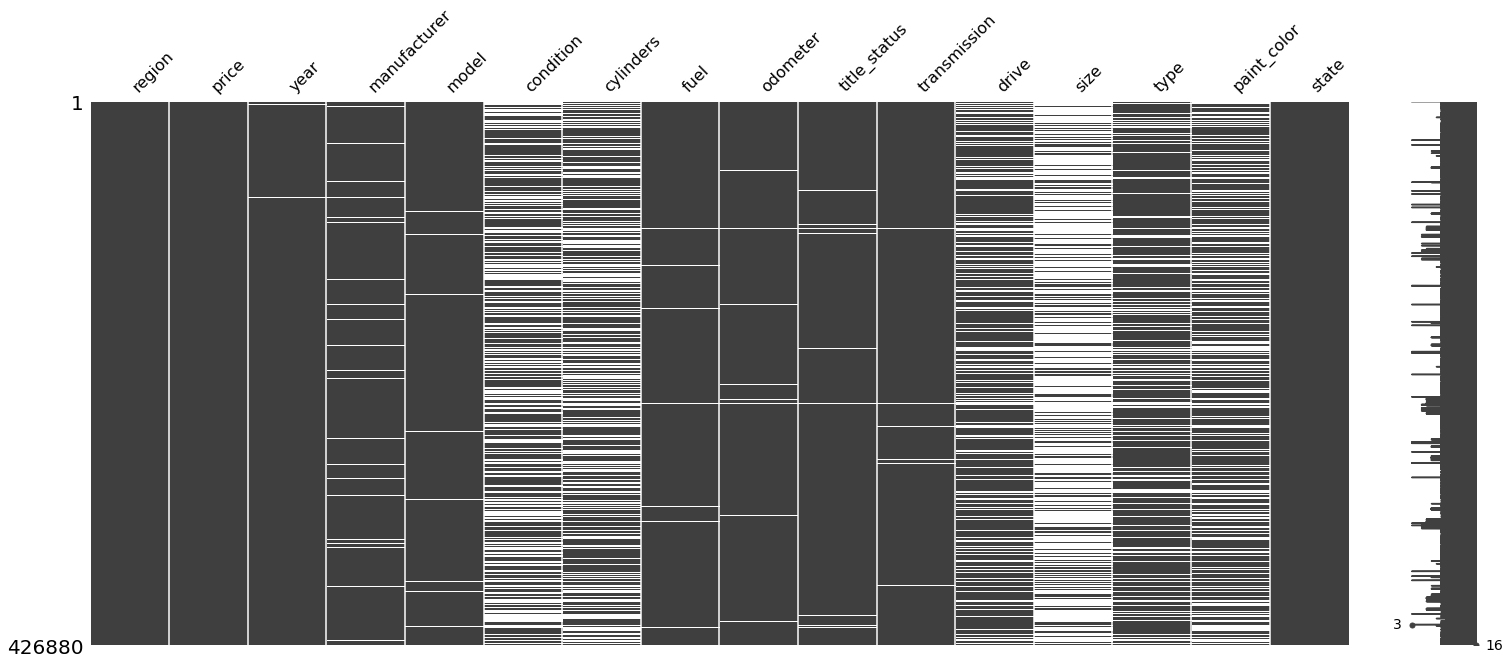

In [10]:
msno.matrix(df)


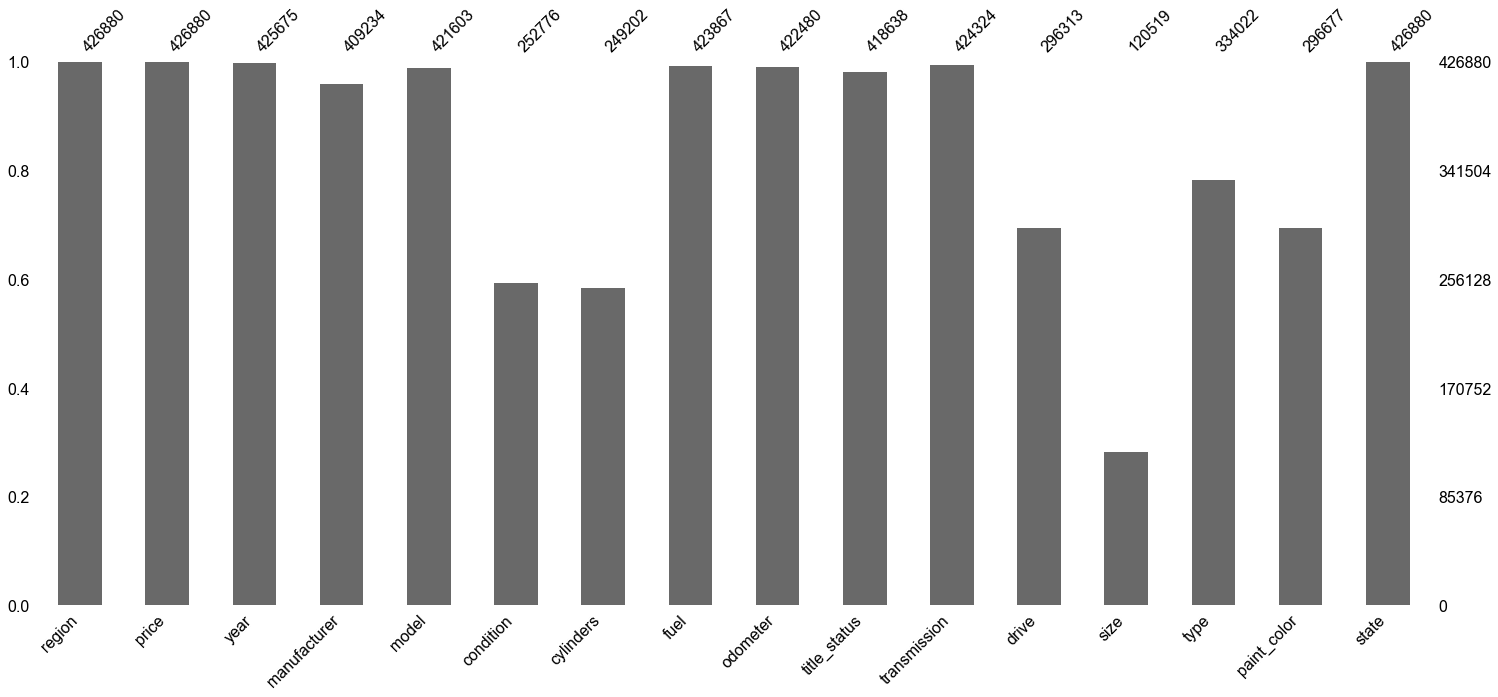

In [11]:
msno.bar(df)
sns.set_style("white")


<AxesSubplot:>

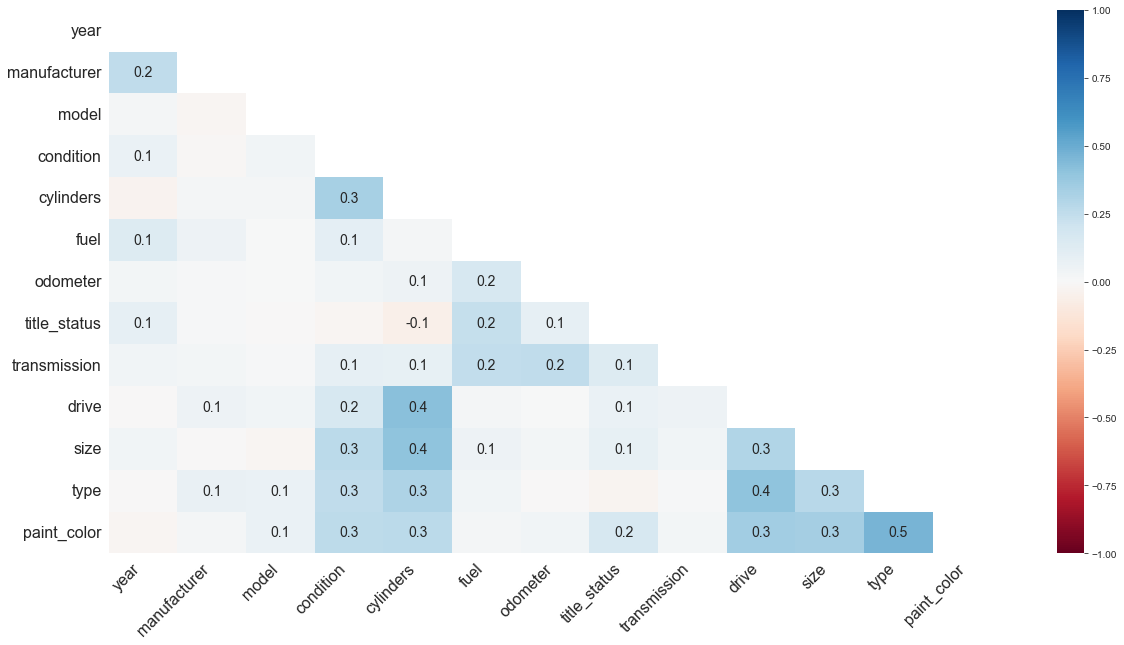

In [12]:
msno.heatmap(df, figsize=(20, 10))

- Nós temos colunas com um alto número de valores faltantes.
- Não parece haver algum padrão em relação aos valores faltantes.


In [13]:
null_values = df.isnull().sum()
null_values_per = round(df.isnull().mean() * 100, 3)

null_df = pd.concat([null_values, null_values_per], axis = 1)
null_df.columns = ['null', 'percent']
null_df.sort_values(ascending=False, by=['percent'])

,null,percent
size,306361,71.767
cylinders,177678,41.622
condition,174104,40.785
drive,130567,30.586
paint_color,130203,30.501
type,92858,21.753
manufacturer,17646,4.134
title_status,8242,1.931
model,5277,1.236
odometer,4400,1.031


- Com 71% dos dados da variável `size` sendo ausentes, não faz sentido manter ela no modelo.

In [14]:
df = df.drop(columns=['size'])

In [15]:
df.shape

(426880, 15)

- Como os dados vem de web scrapping, pode haver muitos erros de digitação de quem imputou os dados. Por causa disso, o melhor caminho para analisar os dados e como vamos lidar com os valores ausentes é fazendo a análise por coluna.

# Análise variáveis númericas: Outliers

## Preço

In [16]:
df['price'].describe()

count    4.268800e+05
mean     7.519903e+04
std      1.218228e+07
min      0.000000e+00
25%      5.900000e+03
50%      1.395000e+04
75%      2.648575e+04
max      3.736929e+09
Name: price, dtype: float64

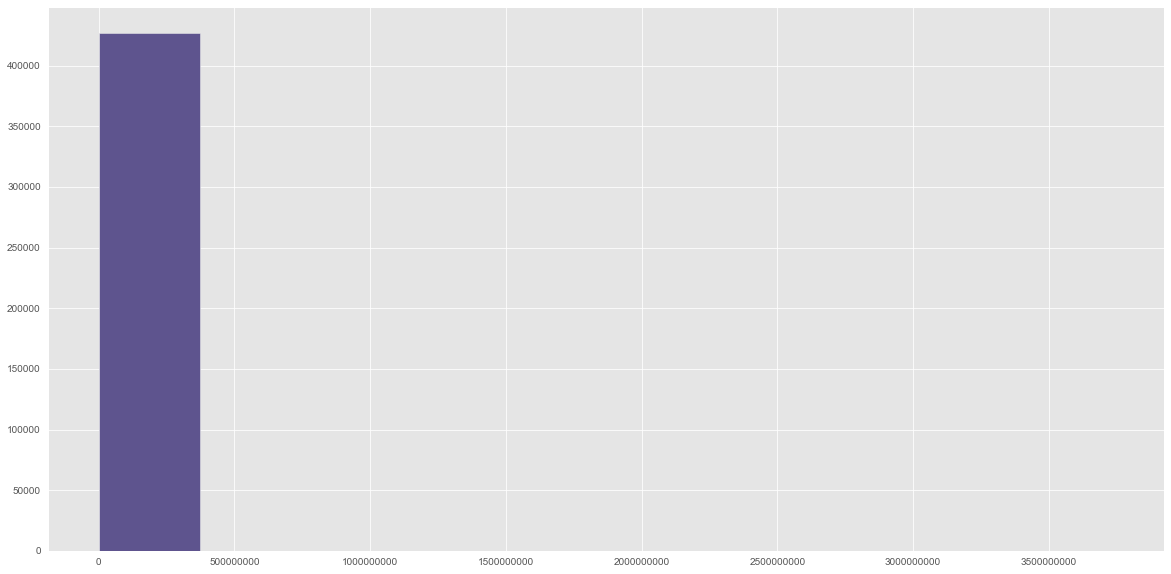

In [17]:
plt.style.use('ggplot')
df['price'].hist(figsize=(20,10), color=['#5e548e'])
plt.ticklabel_format(useOffset=False, style='plain')
plt.show()

- Tem algum outlier muito alto por aqui

In [18]:
df['price'].max()

3736928711

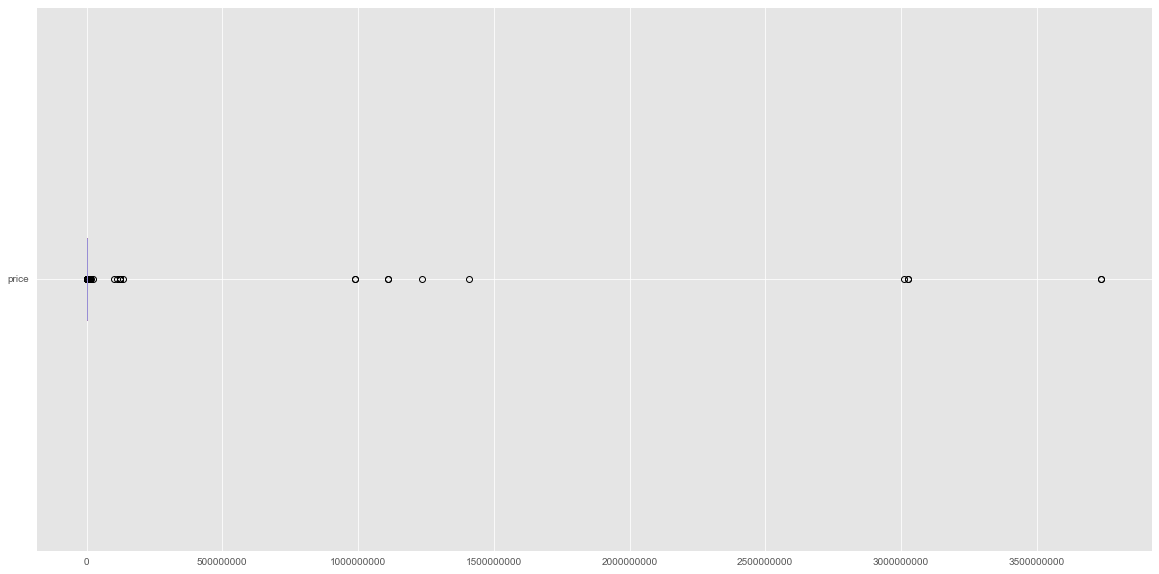

In [20]:
df.boxplot(column=['price'], figsize=(20,10), rot=0, vert=False)
# Configurar formatação dos rótulos no eixo x
plt.ticklabel_format(style='plain', axis='x')
plt.show()

- Vamos eliminar todos os carros com preço maior que 500000000, eles provavelmente são erros de digitação.
- Em seguida repetirei essa etapa de verificar histograma e botplox para procurar os outliers e elimana-los

In [21]:
df = df[df['price'] < 500000000]

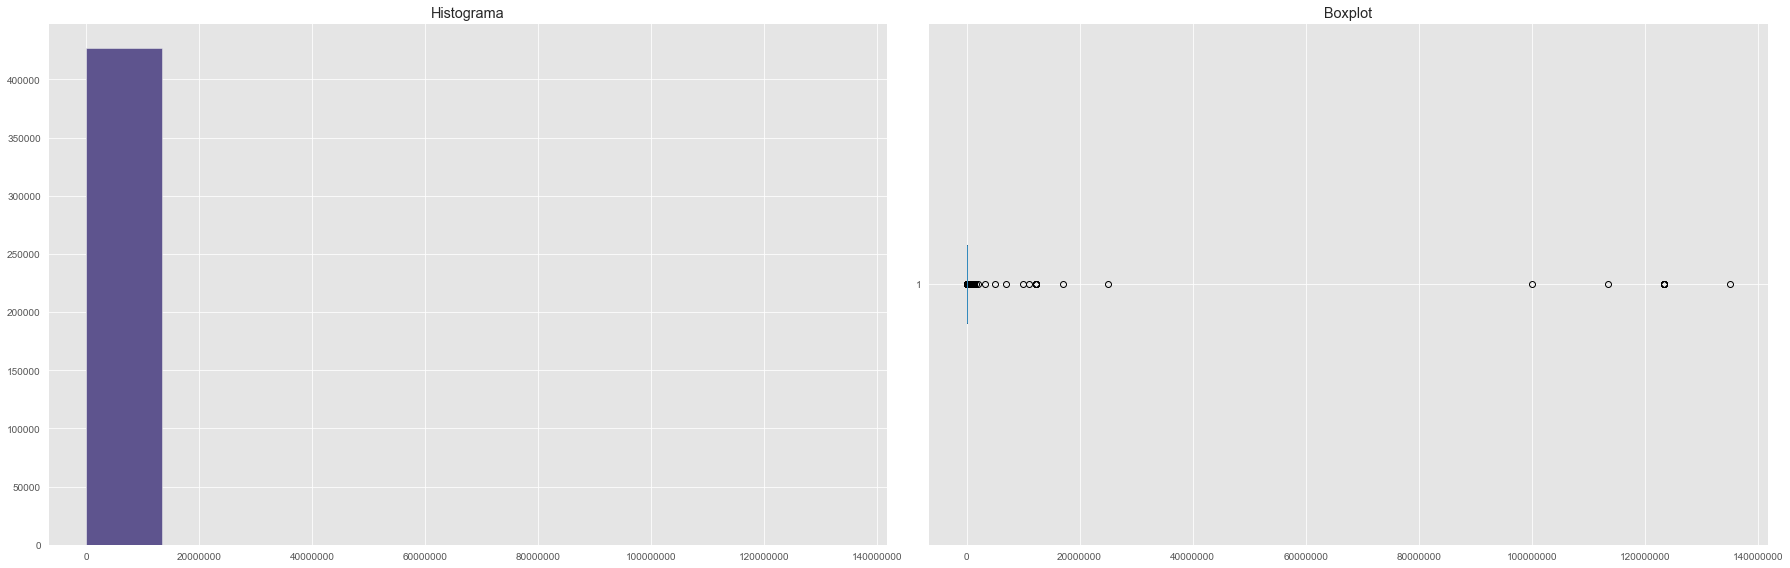

In [22]:
fig, axs = plt.subplots(1, 2, figsize=(25, 8))

# Plotar o histograma no primeiro subplot
axs[0].hist(df['price'], color=['#5e548e'])
axs[0].ticklabel_format(useOffset=False, style='plain')
axs[0].set_title('Histograma')

# Plotar o boxplot no segundo subplot
axs[1].boxplot(df['price'], vert=False)
axs[1].ticklabel_format(style='plain', axis='x')
axs[1].set_title('Boxplot')

plt.tight_layout()

plt.show()

In [ ]:
df = df[df['price'] < 900000]

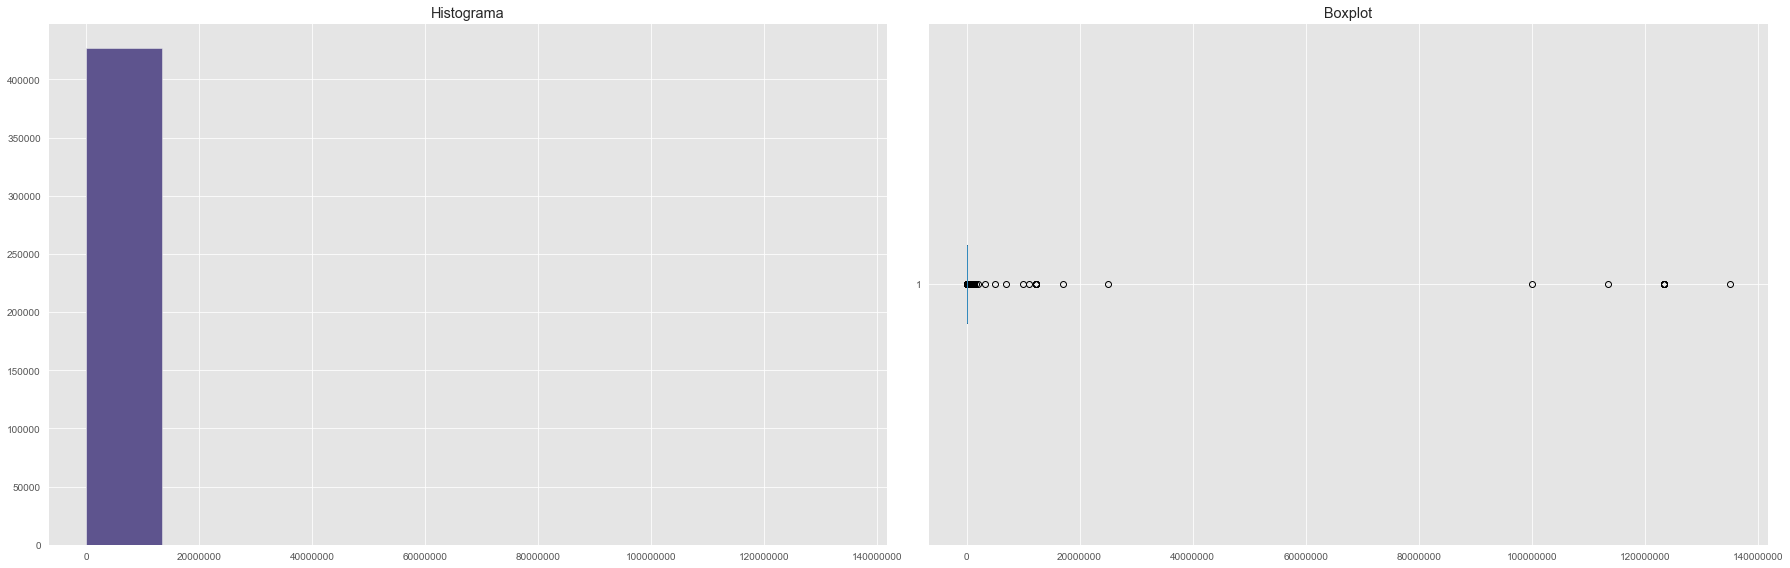

In [23]:
fig, axs = plt.subplots(1, 2, figsize=(25, 8))

# Plotar o histograma no primeiro subplot
axs[0].hist(df['price'], color=['#5e548e'])
axs[0].ticklabel_format(useOffset=False, style='plain')
axs[0].set_title('Histograma')

# Plotar o boxplot no segundo subplot
axs[1].boxplot(df['price'], vert=False)
axs[1].ticklabel_format(style='plain', axis='x')
axs[1].set_title('Boxplot')

plt.tight_layout()
plt.show()

- Cortaremos os outliers mais uma vez, em todos os veículos que custem mais de 150000.

In [24]:
df = df[df['price'] < 150000]

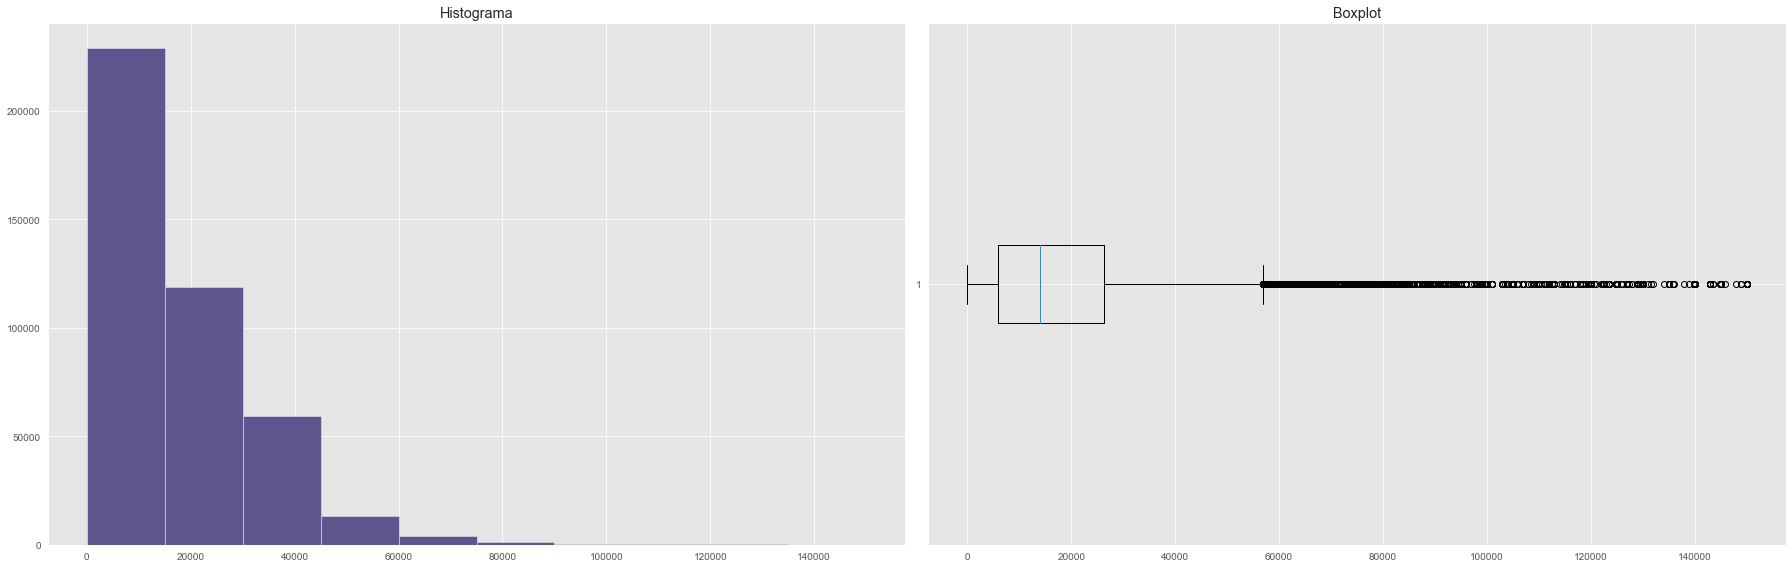

In [25]:
fig, axs = plt.subplots(1, 2, figsize=(25, 8))

# Plotar o histograma no primeiro subplot
axs[0].hist(df['price'], color=['#5e548e'])
axs[0].ticklabel_format(useOffset=False, style='plain')
axs[0].set_title('Histograma')

# Plotar o boxplot no segundo subplot
axs[1].boxplot(df['price'], vert=False)
axs[1].ticklabel_format(style='plain', axis='x')
axs[1].set_title('Boxplot')

plt.tight_layout()
plt.show()

- Podemos ver pela distribuição que temos alguns números em 0. Isso não deveria ocorrer.

In [26]:
df['price'].describe()

count    426673.000000
mean      17382.590124
std       15200.030148
min           0.000000
25%        5900.000000
50%       13950.000000
75%       26300.000000
max      149998.000000
Name: price, dtype: float64

In [27]:
# dataset apenas com numeros diferentes de 0
df = df[df['price'] != 0]

In [28]:
df.describe()

,price,year,odometer
count,393778.000000,392605.000000,3.914910e+05
mean,18834.678108,2011.008543,9.871405e+04
std,14932.907691,9.619726,2.053209e+05
min,1.000000,1900.000000,0.000000e+00
25%,7000.000000,2008.000000,3.800000e+04
50%,15000.000000,2013.000000,8.700000e+04
75%,27590.000000,2017.000000,1.353560e+05
max,149998.000000,2022.000000,1.000000e+07


- Eu decidi como valor arbirtrário que o menor preço seria de 500 USD. Em um cenário real, isso deveria ser conversado e decidido com o time de negócios.

In [29]:
df = df[df['price'] >= 500]

In [30]:
df.describe()

,price,year,odometer
count,384579.000000,383406.000000,3.824600e+05
mean,19280.449231,2010.971808,9.853165e+04
std,14826.289509,9.599994,1.920168e+05
min,500.000000,1900.000000,0.000000e+00
25%,7800.000000,2008.000000,3.822225e+04
50%,15900.000000,2013.000000,8.770200e+04
75%,27990.000000,2017.000000,1.360000e+05
max,149998.000000,2022.000000,1.000000e+07


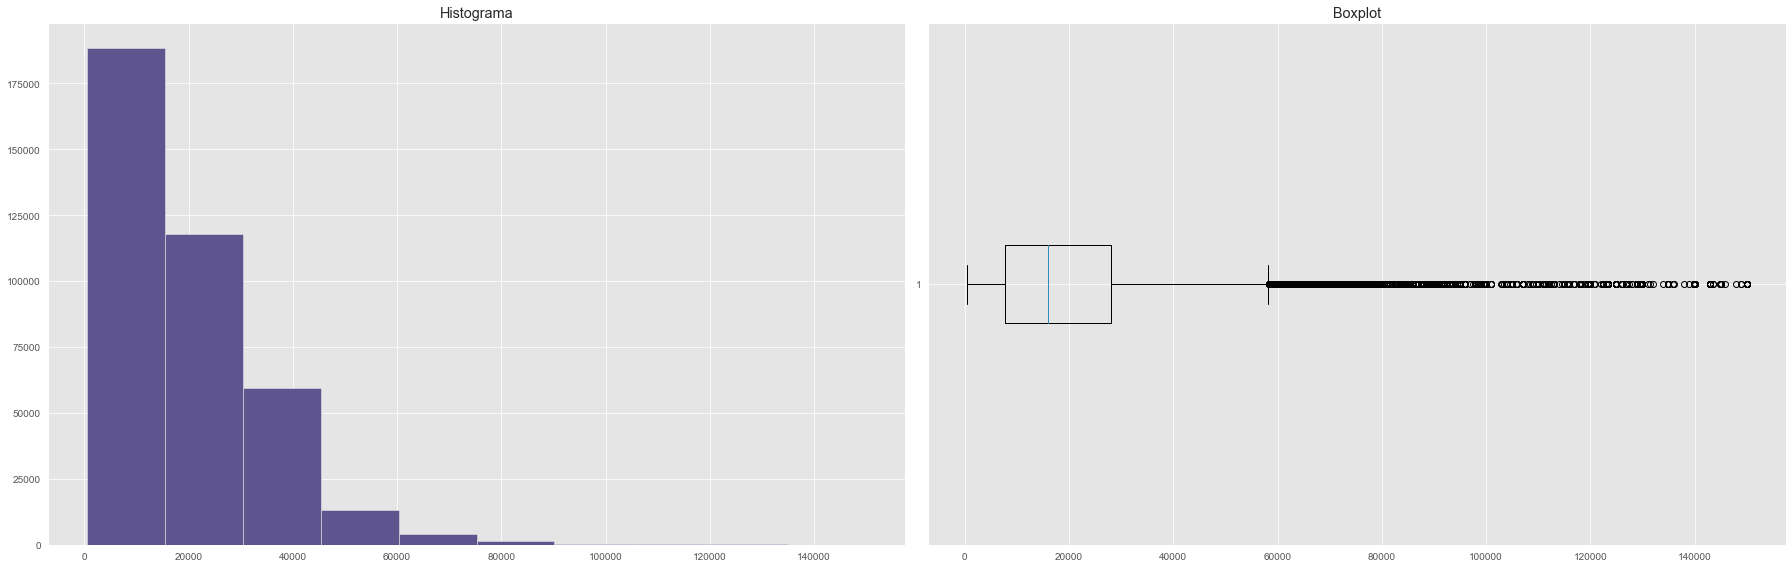

In [31]:
fig, axs = plt.subplots(1, 2, figsize=(25, 8))

# Plotar o histograma no primeiro subplot
axs[0].hist(df['price'], color=['#5e548e'])
axs[0].ticklabel_format(useOffset=False, style='plain')
axs[0].set_title('Histograma')

# Plotar o boxplot no segundo subplot
axs[1].boxplot(df['price'], vert=False)
axs[1].ticklabel_format(style='plain', axis='x')
axs[1].set_title('Boxplot')

plt.tight_layout()
plt.show()

## Variável ano

In [32]:
df['year'].describe()

count    383406.000000
mean       2010.971808
std           9.599994
min        1900.000000
25%        2008.000000
50%        2013.000000
75%        2017.000000
max        2022.000000
Name: year, dtype: float64

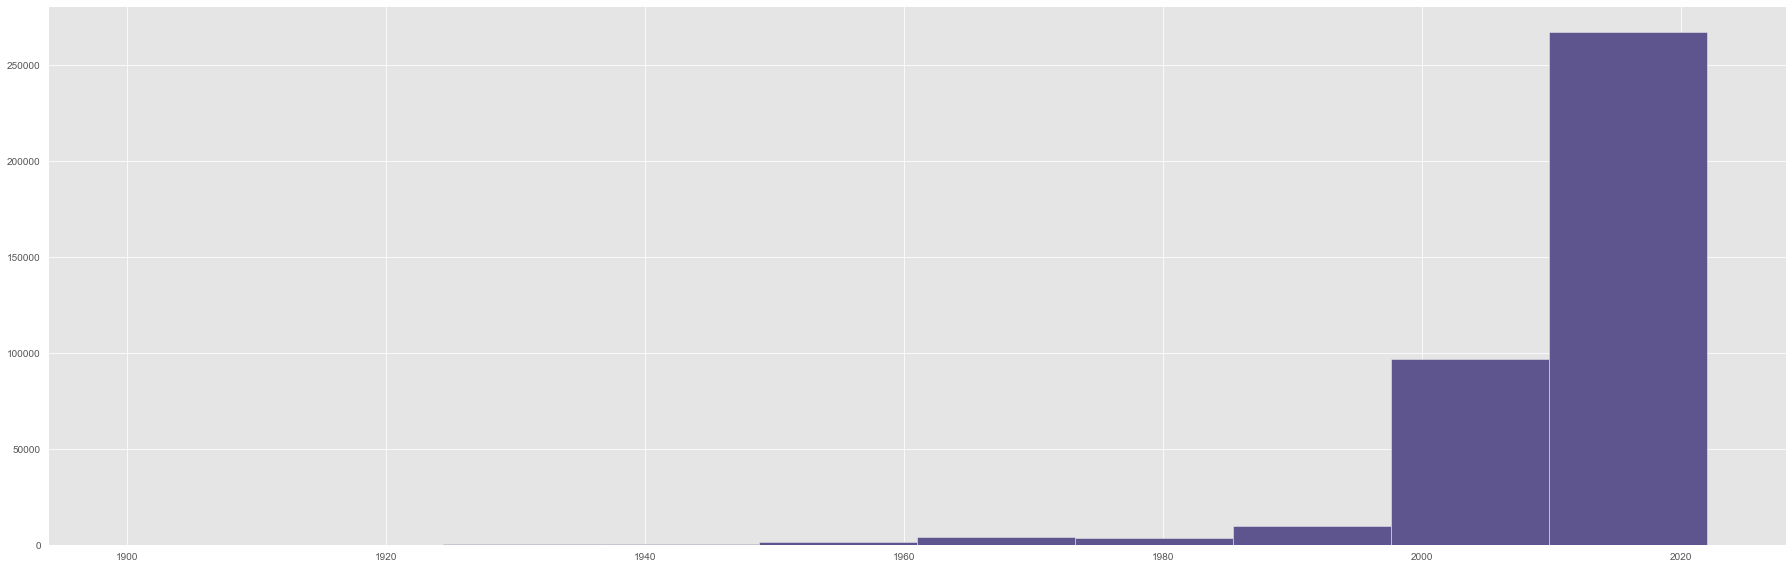

In [34]:
df['year'].hist(figsize=(25, 8), color=['#5e548e'])
plt.tight_layout()
plt.show()

- Vou eliminar todos os dados que são anteriores a 1960.

In [35]:
df = df[df['year'] >=1960]

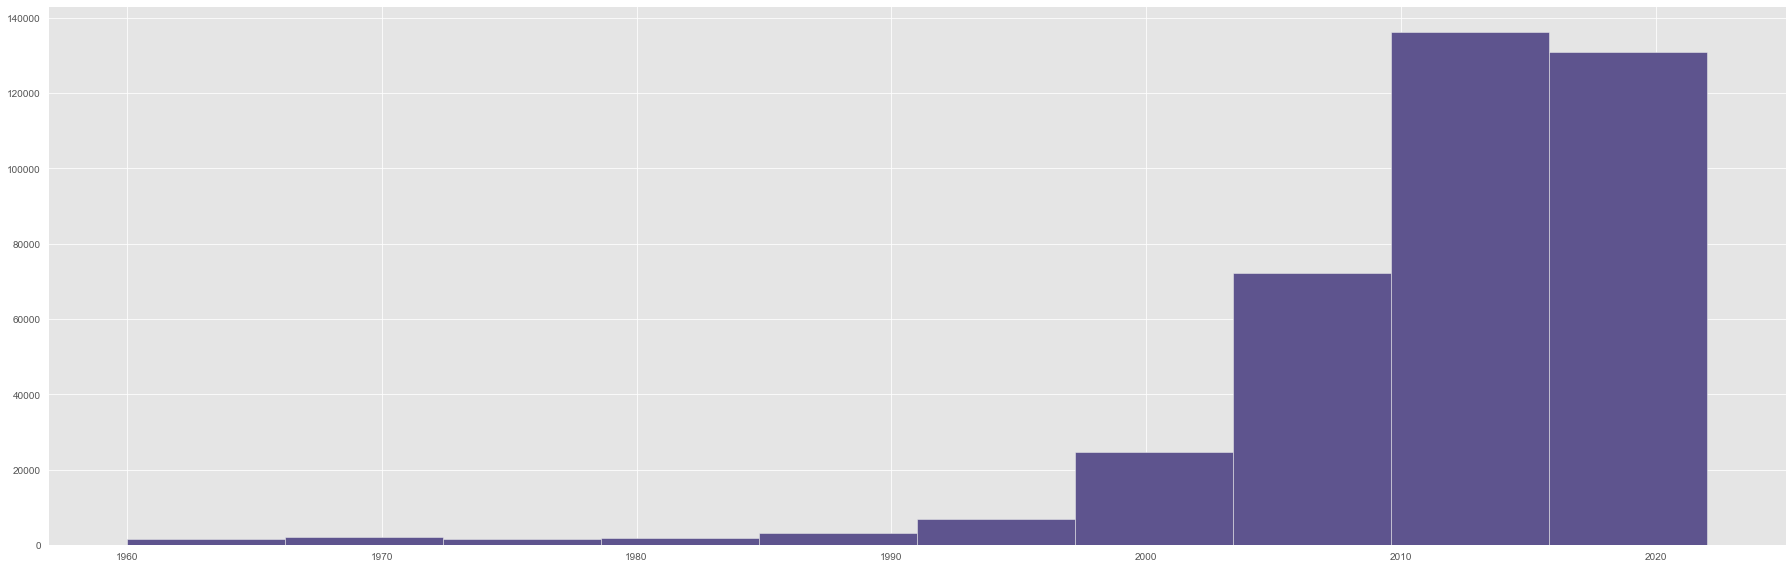

In [36]:
df['year'].hist(figsize=(25, 8), color=['#5e548e'])
plt.tight_layout()
plt.show()

## Variável odometer

In [37]:
df['odometer'].describe()

count    3.790570e+05
mean     9.820996e+04
std      1.752139e+05
min      0.000000e+00
25%      3.897900e+04
50%      8.826100e+04
75%      1.365120e+05
max      1.000000e+07
Name: odometer, dtype: float64

- Vamos olhar o topo da distribuição.

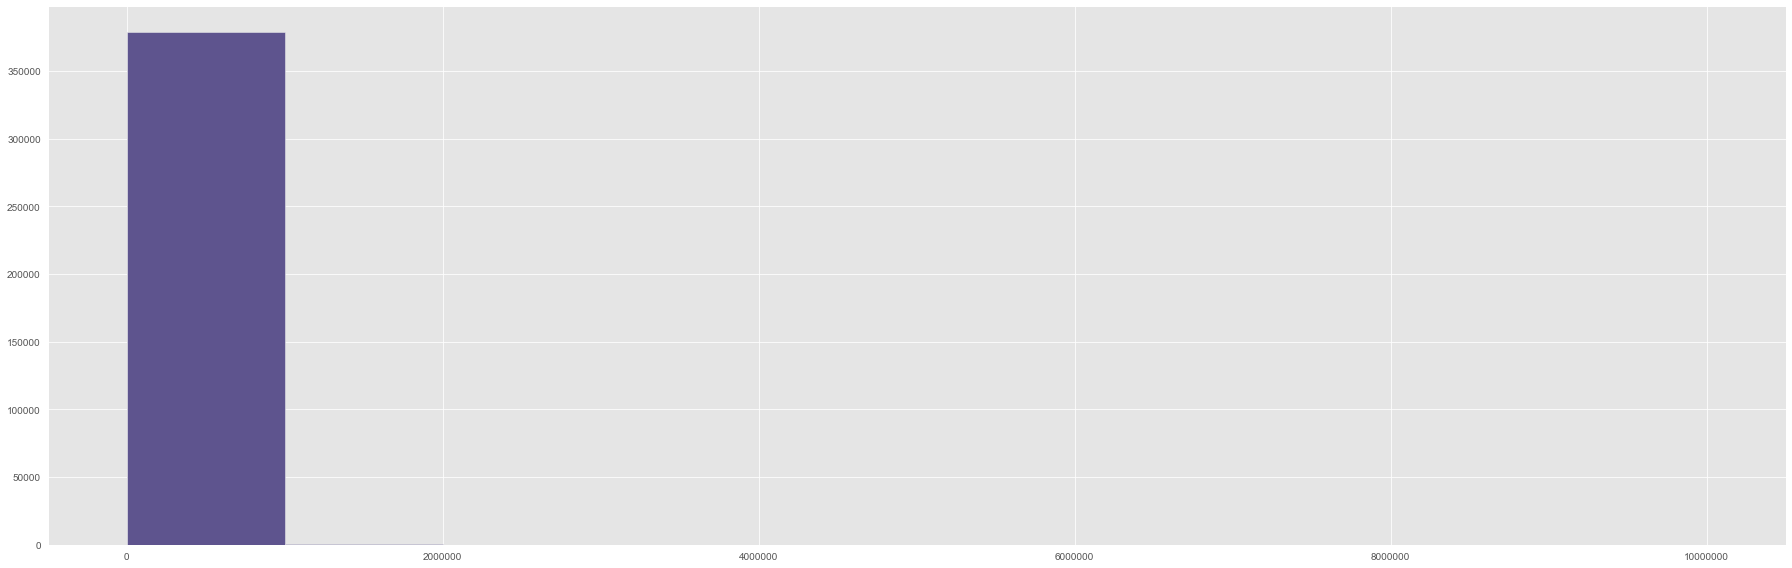

In [38]:
df['odometer'].hist(figsize=(25, 8), color=['#5e548e'])
plt.ticklabel_format(useOffset=False, style='plain')
plt.tight_layout()
plt.show()

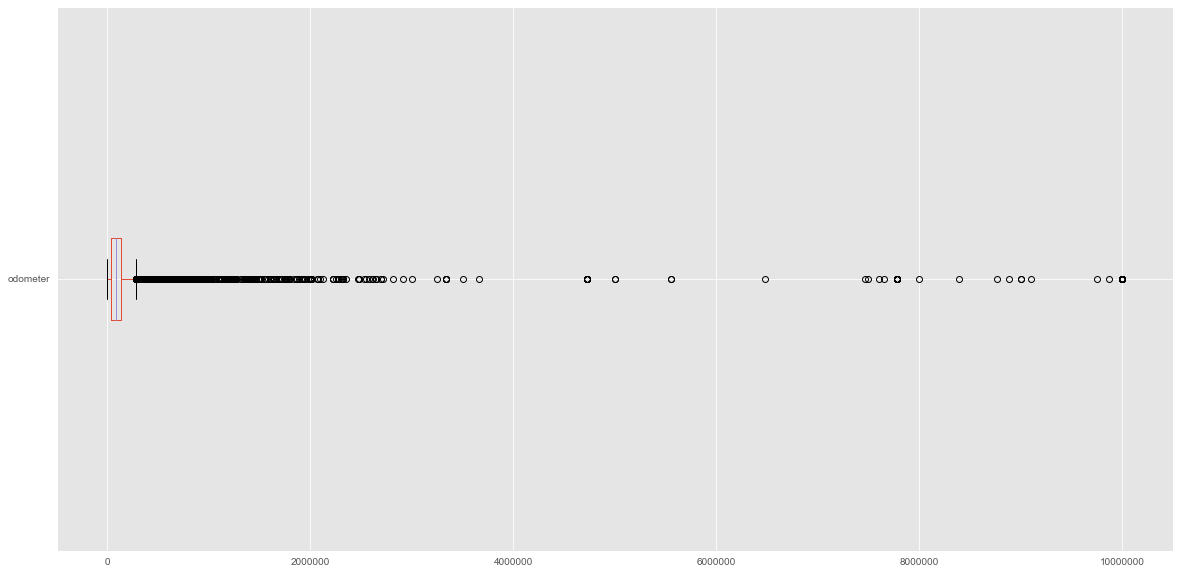

In [39]:
df.boxplot(column=['odometer'], figsize=(20,10), rot=0, vert=False)
# Configurar formatação dos rótulos no eixo x
plt.ticklabel_format(style='plain', axis='x')
plt.show()

- Vamos eliminar todos os valores acima de 400000 e iguais a 0.

In [40]:
df = df[(df['odometer'] <= 400000) & (df['odometer'] != 0)]

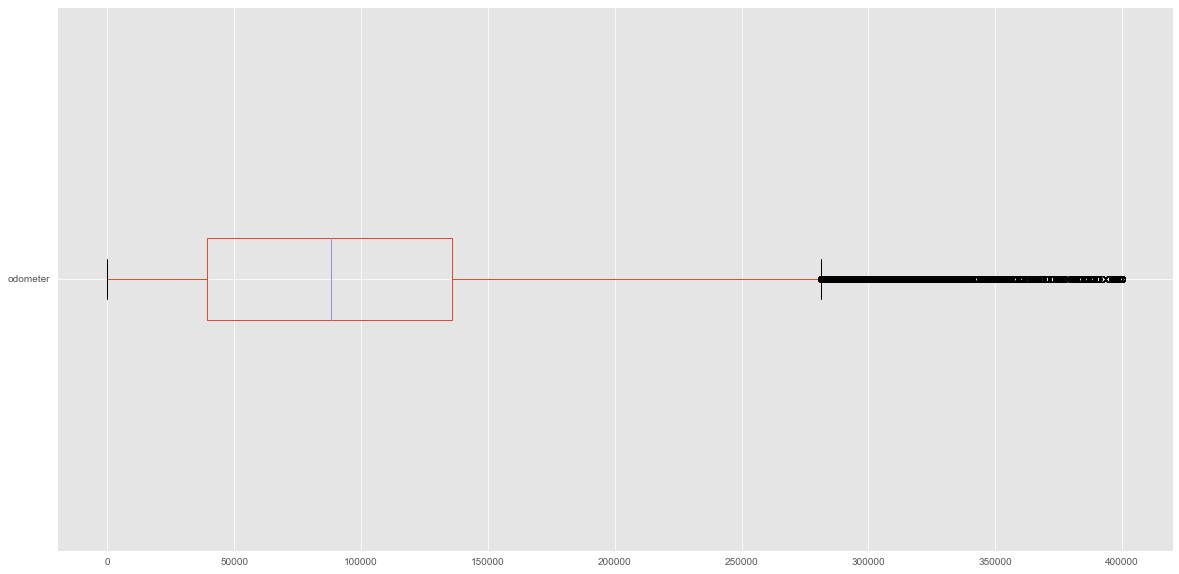

In [41]:
df.boxplot(column=['odometer'], figsize=(20,10), rot=0, vert=False)
# Configurar formatação dos rótulos no eixo x
plt.ticklabel_format(style='plain', axis='x')
plt.show()

- Muito melhor

In [42]:
df.shape

(376778, 15)

- Saimos de 426880 para 376778 observações. Vamos começar a lidar com os dados ausentes.

# Imputando dados ausentes

In [43]:
df = df.reset_index(drop = True)

In [44]:
df.head()

,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,type,paint_color,state
0,auburn,33590,2014.0,gmc,sierra 1500 crew cab slt,good,8 cylinders,gas,57923.0,clean,other,NaN,pickup,white,al
1,auburn,22590,2010.0,chevrolet,silverado 1500,good,8 cylinders,gas,71229.0,clean,other,NaN,pickup,blue,al
2,auburn,39590,2020.0,chevrolet,silverado 1500 crew,good,8 cylinders,gas,19160.0,clean,other,NaN,pickup,red,al
3,auburn,30990,2017.0,toyota,tundra double cab sr,good,8 cylinders,gas,41124.0,clean,other,NaN,pickup,red,al
4,auburn,15000,2013.0,ford,f-150 xlt,excellent,6 cylinders,gas,128000.0,clean,automatic,rwd,truck,black,al


In [45]:
 df.isnull().sum()

region               0
price                0
year                 0
manufacturer     13168
model             4002
condition       142205
cylinders       154109
fuel              2086
odometer             0
title_status      6238
transmission      1508
drive           114428
type             80651
paint_color     108755
state                0
dtype: int64

In [46]:
round(df.isnull().mean() * 100, 3)

region           0.000
price            0.000
year             0.000
manufacturer     3.495
model            1.062
condition       37.742
cylinders       40.902
fuel             0.554
odometer         0.000
title_status     1.656
transmission     0.400
drive           30.370
type            21.405
paint_color     28.864
state            0.000
dtype: float64

### Variável: Condition

Para lidar  com os valores faltantes na coluna `Condition` vou seguir o exemplo de outros notebooks do Kaggle 
[[1](https://github.com/mo-adi/used_cars_pricing)] [[2](https://www.kaggle.com/code/msagmj/data-cleaning-eda-used-cars-prediction-86)]:
1. iremos achar o valor faltante utilizando a coluna de `odometer`. Nós iremos ver a média do `odometer` em cada `condition` e usar essas médias em relação a cada condição para imputar os valores. Porém qualquer carro que seja do ano de 2022 ou mais novo receberá a condição de novo, independente de quanto for seu hodomêtro. 

In [47]:
df['condition'].value_counts(normalize=True)

good         0.499960
excellent    0.384051
like new     0.082810
fair         0.026819
new          0.004165
salvage      0.002195
Name: condition, dtype: float64

In [48]:
good_odo_mean = df[df['condition'] == 'good']['odometer'].mean()
excelent_odo_mean = df[df['condition'] == 'excellent']['odometer'].mean()
like_new_odo_mean = df[df['condition'] == 'like new']['odometer'].mean()
fair_odo_mean = df[df['condition'] == 'fair']['odometer'].mean()
new_odo_mean = df[df['condition'] == 'new']['odometer'].mean()
salvage_odo_mean = df[df['condition'] == 'salvage']['odometer'].mean()


In [49]:
print('Média do hodômetro - good:', round(good_odo_mean, 2))
print('Média do hodômetro - excellent:', round(excelent_odo_mean, 2))
print('Média do hodômetro - like new:', round(like_new_odo_mean, 2))
print('Média do hodômetro - fair:', round(fair_odo_mean, 2))
print('Média do hodômetro - new:', round(new_odo_mean, 2))
print('Média do hodômetro - salvage:', round(salvage_odo_mean, 2))

Média do hodômetro - good: 77068.61
Média do hodômetro - excellent: 107159.44
Média do hodômetro - like new: 81447.85
Média do hodômetro - fair: 165347.4
Média do hodômetro - new: 49798.95
Média do hodômetro - salvage: 141128.16


In [50]:
df.loc[df['odometer'] <= good_odo_mean, 'condition'] = df.loc[df['odometer'] <= good_odo_mean, 'condition'].fillna('new')
df.loc[df['odometer'] >= fair_odo_mean, 'condition'] = df.loc[df['odometer'] >= fair_odo_mean, 'condition'].fillna('fair')
df.loc[((df['odometer'] >= good_odo_mean) & (df['odometer'] < like_new_odo_mean)), 'condition'] = df.loc[((df['odometer'] >= good_odo_mean) & (df['odometer'] < like_new_odo_mean)), 'condition'].fillna('good')
df.loc[((df['odometer'] >= like_new_odo_mean) & (df['odometer'] < excelent_odo_mean)), 'condition'] = df.loc[((df['odometer'] >= like_new_odo_mean) & (df['odometer'] < excelent_odo_mean)), 'condition'].fillna('like new')
df.loc[((df['odometer'] >= excelent_odo_mean) & (df['odometer'] < salvage_odo_mean)), 'condition'] = df.loc[((df['odometer'] >= excelent_odo_mean) & (df['odometer'] < salvage_odo_mean)), 'condition'].fillna('excellent')
df.loc[((df['odometer'] >= salvage_odo_mean) & (df['odometer'] < fair_odo_mean)), 'condition'] = df.loc[((df['odometer'] >= salvage_odo_mean) & (df['odometer'] < fair_odo_mean)), 'condition'].fillna('salvage')


In [51]:
df.loc[(df['year'] >= 2022) & df['condition'].isnull(), 'condition'] = 'new'


In [52]:
round(df.isnull().mean() * 100, 3)



region           0.000
price            0.000
year             0.000
manufacturer     3.495
model            1.062
condition        0.000
cylinders       40.902
fuel             0.554
odometer         0.000
title_status     1.656
transmission     0.400
drive           30.370
type            21.405
paint_color     28.864
state            0.000
dtype: float64

### Variáveis com menos de 5% de valores faltantes

Vamos lidar com as variáveis que tem menos de 5% de valores nulos eliminado-as da amostra. Vamos eliminar os valores nulos de `transmission`, `model`, `manufacturer`, `fuel`.

In [53]:
df = df.dropna(subset=['transmission', 'model', 'manufacturer','fuel'])

In [54]:
round(df.isnull().mean() * 100, 3)


region           0.000
price            0.000
year             0.000
manufacturer     0.000
model            0.000
condition        0.000
cylinders       40.462
fuel             0.000
odometer         0.000
title_status     1.584
transmission     0.000
drive           29.988
type            20.823
paint_color     28.520
state            0.000
dtype: float64

### Variável title_status

In [55]:
df['title_status'].value_counts()

clean         338632
rebuilt         6663
salvage         3540
lien            1302
missing          394
parts only        95
Name: title_status, dtype: int64

- Vamos imputar os valores faltantes com a categoria `missing`

In [56]:
df.loc[:, 'title_status'] = df['title_status'].fillna('missing')


In [57]:
df['title_status'].value_counts()

clean         338632
rebuilt         6663
missing         6038
salvage         3540
lien            1302
parts only        95
Name: title_status, dtype: int64

In [58]:
round(df.isnull().mean() * 100, 3)


region           0.000
price            0.000
year             0.000
manufacturer     0.000
model            0.000
condition        0.000
cylinders       40.462
fuel             0.000
odometer         0.000
title_status     0.000
transmission     0.000
drive           29.988
type            20.823
paint_color     28.520
state            0.000
dtype: float64

### Variável cylinders

In [59]:
df['cylinders'].value_counts()

6 cylinders     81730
4 cylinders     66291
8 cylinders     60211
5 cylinders      1479
10 cylinders     1066
other             755
3 cylinders       485
12 cylinders       98
Name: cylinders, dtype: int64

A variável `cylinders` tem 40% dos dados ausentes, então não é possível dropar os valores ausentes. A solução encontrada foi imputar com a moda. Isso pode gerar algum viés para o modelo, mas como não é possível falar com um time de negócios, é a melhor saída encontrada.

In [60]:
df.loc[:, 'cylinders'] = df['cylinders'].fillna('6 cylinders')


In [61]:
round(df.isnull().mean() * 100, 3)


region           0.000
price            0.000
year             0.000
manufacturer     0.000
model            0.000
condition        0.000
cylinders        0.000
fuel             0.000
odometer         0.000
title_status     0.000
transmission     0.000
drive           29.988
type            20.823
paint_color     28.520
state            0.000
dtype: float64

### Variável type

In [62]:
df['type'].value_counts()

sedan          73799
SUV            65384
pickup         38747
truck          27682
other          18158
coupe          15851
hatchback      14279
wagon           9342
van             7341
convertible     6467
mini-van        4259
offroad          518
bus              257
Name: type, dtype: int64

A variável type tem por volta de 20% dos dados ausentes. As categorias tem valors muito parecidos e se eu imputasse pela moda poderia gerar um viés desproporcional. Também não é possível cortar 20% dos dados. Como eu não queria dropar os dados e não via muito sentido agrupar todas como `sedan` e influenciar o modelo de aprendizado de alguma maneira negativa, optei por colocar esses valores na categoria `other`.

In [63]:
df.loc[:, 'type'] = df['type'].fillna('other')


In [64]:
round(df.isnull().mean() * 100, 3)


region           0.000
price            0.000
year             0.000
manufacturer     0.000
model            0.000
condition        0.000
cylinders        0.000
fuel             0.000
odometer         0.000
title_status     0.000
transmission     0.000
drive           29.988
type             0.000
paint_color     28.520
state            0.000
dtype: float64

### Variável drive e paint_color

In [65]:
print(df['drive'].value_counts())
print(df['paint_color'].value_counts())

4wd    111929
fwd     89916
rwd     47587
Name: drive, dtype: int64
white     66482
black     54942
silver    37582
blue      27197
red       26111
grey      21201
green      6048
brown      5789
custom     5612
orange     1582
yellow     1558
purple      559
Name: paint_color, dtype: int64


As duas útilmas variáveis serão preenchidas utilizando a técninca de `Forward Fill`. `Forward Fill` é uma técnica de imputação de dados ausentes que envolve substituir os dados ausentes com o valor mais recente conhecido. Esta abordagem assume que os valores são constantes até que uma nova observação esteja disponível. Ao usar observações prévias como substitutas, esta técninca ajuda a manter a continuidade dos dados. Esta técnica é frequentemente utilizada quando os dados faltantes são considerados aleatórios. Esse método foi escolhido por que os valores das categorias nas duas variáveis são próximos e não faria sentido dropar os valores nulos ou criar uma nova categoria/imputar moda.

In [66]:
df['paint_color'] = df['paint_color'].fillna(method='ffill')
df['drive'] = df['drive'].fillna(method='ffill')

In [67]:
round(df.isnull().mean() * 100, 3)


region          0.000
price           0.000
year            0.000
manufacturer    0.000
model           0.000
condition       0.000
cylinders       0.000
fuel            0.000
odometer        0.000
title_status    0.000
transmission    0.000
drive           0.001
type            0.000
paint_color     0.000
state           0.000
dtype: float64

Ainda sobrou alguns NAs, eu vou retirar do dataset:

In [68]:
df[df['drive'].isnull()]

,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,type,paint_color,state
0,auburn,33590,2014.0,gmc,sierra 1500 crew cab slt,good,8 cylinders,gas,57923.0,clean,other,NaN,pickup,white,al
1,auburn,22590,2010.0,chevrolet,silverado 1500,good,8 cylinders,gas,71229.0,clean,other,NaN,pickup,blue,al
2,auburn,39590,2020.0,chevrolet,silverado 1500 crew,good,8 cylinders,gas,19160.0,clean,other,NaN,pickup,red,al
3,auburn,30990,2017.0,toyota,tundra double cab sr,good,8 cylinders,gas,41124.0,clean,other,NaN,pickup,red,al


In [69]:
df=df.dropna(subset=['drive'])

In [70]:
round(df.isnull().mean() * 100, 3)


region          0.0
price           0.0
year            0.0
manufacturer    0.0
model           0.0
condition       0.0
cylinders       0.0
fuel            0.0
odometer        0.0
title_status    0.0
transmission    0.0
drive           0.0
type            0.0
paint_color     0.0
state           0.0
dtype: float64

In [71]:
df.shape

(356266, 15)

In [72]:
df.head()

,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,type,paint_color,state
4,auburn,15000,2013.0,ford,f-150 xlt,excellent,6 cylinders,gas,128000.0,clean,automatic,rwd,truck,black,al
5,auburn,27990,2012.0,gmc,sierra 2500 hd extended cab,good,8 cylinders,gas,68696.0,clean,other,4wd,pickup,black,al
6,auburn,34590,2016.0,chevrolet,silverado 1500 double,good,6 cylinders,gas,29499.0,clean,other,4wd,pickup,silver,al
7,auburn,35000,2019.0,toyota,tacoma,excellent,6 cylinders,gas,43000.0,clean,automatic,4wd,truck,grey,al
8,auburn,29990,2016.0,chevrolet,colorado extended cab,good,6 cylinders,gas,17302.0,clean,other,4wd,pickup,red,al


In [73]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 356266 entries, 4 to 376777
Data columns (total 15 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   region        356266 non-null  object 
 1   price         356266 non-null  int64  
 2   year          356266 non-null  float64
 3   manufacturer  356266 non-null  object 
 4   model         356266 non-null  object 
 5   condition     356266 non-null  object 
 6   cylinders     356266 non-null  object 
 7   fuel          356266 non-null  object 
 8   odometer      356266 non-null  float64
 9   title_status  356266 non-null  object 
 10  transmission  356266 non-null  object 
 11  drive         356266 non-null  object 
 12  type          356266 non-null  object 
 13  paint_color   356266 non-null  object 
 14  state         356266 non-null  object 
dtypes: float64(2), int64(1), object(12)
memory usage: 43.5+ MB


In [74]:
df.reset_index(drop=True, inplace=True)

In [75]:
df.head()

,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,type,paint_color,state
0,auburn,15000,2013.0,ford,f-150 xlt,excellent,6 cylinders,gas,128000.0,clean,automatic,rwd,truck,black,al
1,auburn,27990,2012.0,gmc,sierra 2500 hd extended cab,good,8 cylinders,gas,68696.0,clean,other,4wd,pickup,black,al
2,auburn,34590,2016.0,chevrolet,silverado 1500 double,good,6 cylinders,gas,29499.0,clean,other,4wd,pickup,silver,al
3,auburn,35000,2019.0,toyota,tacoma,excellent,6 cylinders,gas,43000.0,clean,automatic,4wd,truck,grey,al
4,auburn,29990,2016.0,chevrolet,colorado extended cab,good,6 cylinders,gas,17302.0,clean,other,4wd,pickup,red,al


In [ ]:
df.to_csv('df_clean.csv', index=False)